In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvi

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import the data
Data will be in scanpy anndata type


In [2]:
rawPath = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "Datasets", "DUSP1", "A1-2_sc_Bulk_GSE141834", 'GSE141834_scRNAseq_rawCounts.txt')
adata = sc.read_text(rawPath).T
adata.write_h5ad("GSE141834_scRNAseq_rawCounts.h5ad")

# Quality Contorl
Genes and cells that dont contribute information <br>
based on: genes that arent in at least 10 cells and cells that dont have at least 100 genes

In [3]:
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.filter_cells(adata, min_genes = 100)

Creates a 'mt' and 'ribo' column in var dataframe, <br>
with boolean values incicateing if the gene is a <br>
a mitochondrial and rRNA<br>
then creates several measurements obs and var <br>



In [4]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

Display QC variables 

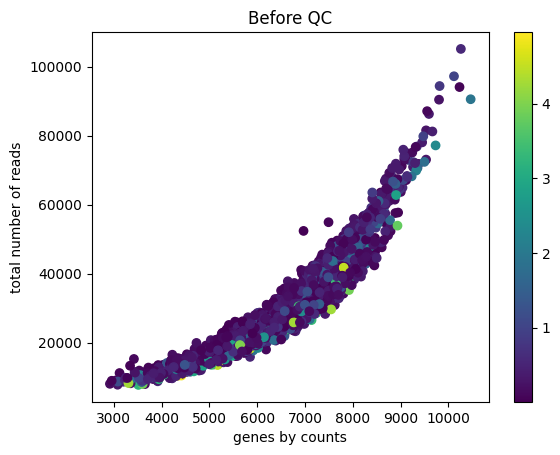

In [5]:
plt.scatter(adata.obs['n_genes_by_counts'], adata.obs['total_counts'], c=adata.obs['pct_counts_mt'])
plt.xlabel('genes by counts')
plt.ylabel('total number of reads')
plt.title("Before QC")
plt.colorbar()
plt.show()

Saves raw data to counts layer 

In [6]:
adata.layers['counts'] = adata.X

Seurat_v3 highly variable genes saved to seurat_V3_HV <br>
as boolean

In [7]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes = 4000)

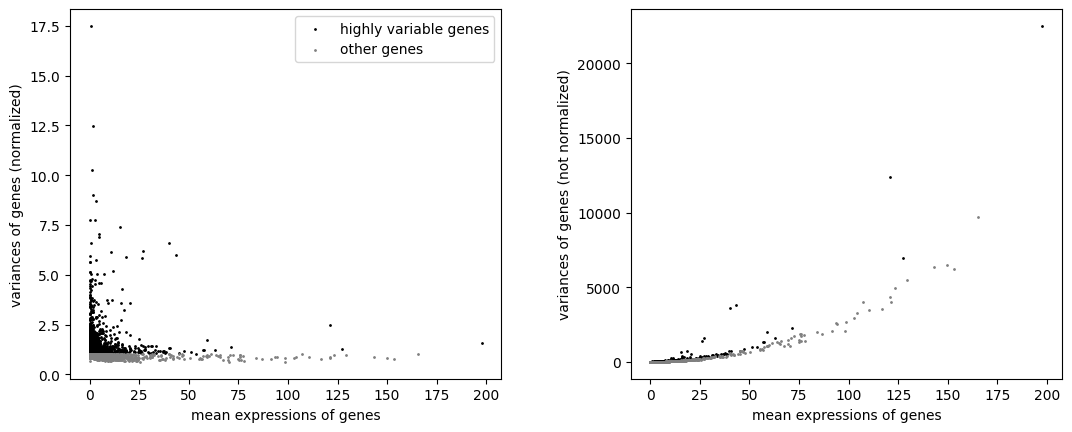

In [8]:
adata.var['seurat_v3_HVG'] = adata.var['highly_variable']
sc.pl.highly_variable_genes(adata)

Normalize data to 10,000 counts 

In [9]:
sc.pp.normalize_total(adata, target_sum = 1e5)


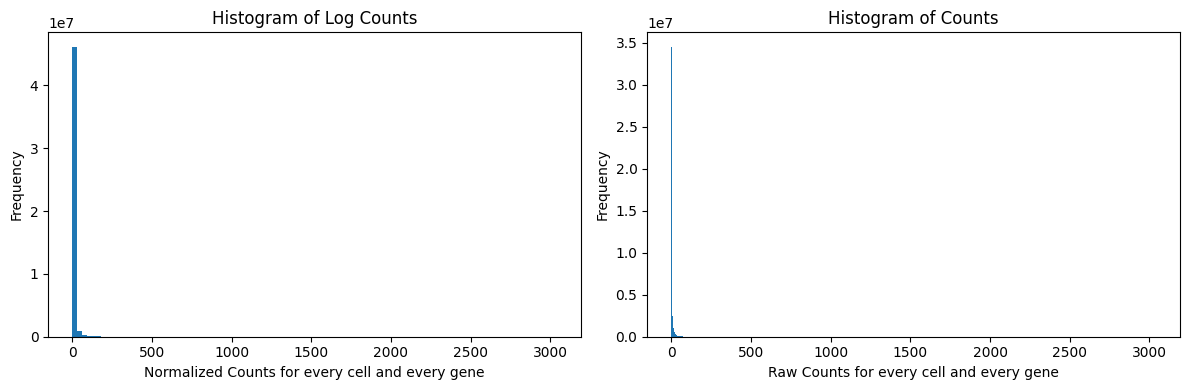

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Normalized Counts
axs[0].hist(adata.X.flatten(), bins=100)
axs[0].set_xlabel('Normalized Counts for every cell and every gene')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Log Counts')

# Plot 2: Counts
axs[1].hist(adata.layers['counts'].flatten(), bins=1000)
axs[1].set_xlabel('Raw Counts for every cell and every gene')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Counts')

plt.tight_layout()
plt.show()


Converts data to log(x + 1)

In [11]:
sc.pp.log1p(adata)
adata.raw = adata

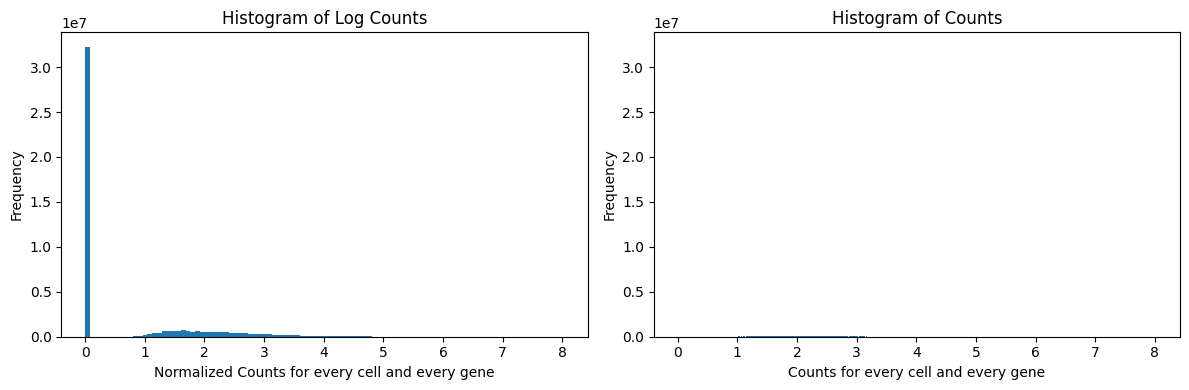

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Log Counts
axs[0].hist(adata.X.flatten(), bins=100)
axs[0].set_xlabel('Normalized Counts for every cell and every gene')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Log Counts')

# Plot 2: Raw Counts
axs[1].hist(adata.layers['counts'].flatten(), bins=1000)
axs[1].set_xlabel('Counts for every cell and every gene')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Counts')

plt.tight_layout()
plt.show()


Adds Timepoint to obs, strings of a XX format strings for each TP <br>
Add Treatment to obs, strings that are Dex 

In [13]:
adata.obs['Timepoint'] = [x.split('.')[1] for x in adata.obs_names]
adata.obs['Treatment'] = [x.split('.')[0] for x in adata.obs_names]

adata.obs['Timepoint'] = adata.obs['Timepoint']
adata.obs['Treatment'] = adata.obs['Treatment']

Removes none Dex treated cells

In [14]:
adata = adata[adata.obs['Treatment'] == 'Dex']

Checks to make sure all vars are only gene

In [15]:
lsChecks = [
    'day', 'DUSP1', 'hashtag', 'timepoint', 'treatment', 'treatment_timepoint', 'treatment_timepoint_day', 'treatment_day', 'treatment_timepoint_day',
    'treatment_timepoint', 'treatment_timepoint_day', 'treatment_day', 'treatment_timepoint_day', 'treatment_timepoint', 'treatment_timepoint_day', 'hash',
    'tag' 

]

new_tags = ['experiment_id', 'sample_id', 'batch', 'cell_type', 
            'condition', 'replicate', 'protocol', 'operator', 'date', 
            'location', 'species', 'strain', 'sex', 'age', 'developmental_stage', 
            'tissue', 'organ', 'cell_line', 'disease_state', 'platform', 'sequencing_depth', 
            'read_length', 'library_type', 'experiment_type', 'analysis_software', 'sample', 'type', 'name', 'id', 'group',
            'experiment', 'cell', 'read', 'type', adata.var_names[483]]

lsChecks.extend(new_tags)

new_tags = ['genotype', 'phenotype', 'molecule', 'barcode', 'cell_cycle', 'population', 
            'cluster', 'subpopulation', 'marker', 'antibody', 'probe', 'primer', 'temperature', 
            'humidity', 'pressure', 'light_cycle', 'food_source', 'lifecycle_stage', 'growth_conditions', 
            'experiment_conditions', 'lab', 'researcher', 'project', 'publication', 'cycle', 'dex', adata.var_names[1849], 'GH', 'dusp']


lsChecks.extend(new_tags)
print(len(lsChecks))
for i in lsChecks:
    for name in adata.var_names:
        if i.lower() in name.lower():
            print(f'{i} is in the var_names, {name}')




81
DUSP1 is in the var_names, DUSP13
DUSP1 is in the var_names, DUSP1
DUSP1 is in the var_names, DUSP18
DUSP1 is in the var_names, DUSP11
DUSP1 is in the var_names, DUSP12
DUSP1 is in the var_names, DUSP14
DUSP1 is in the var_names, DUSP16
DUSP1 is in the var_names, DUSP19
DUSP1 is in the var_names, DUSP10
DUSP1 is in the var_names, DUSP15
tag is in the var_names, STAG3L3
tag is in the var_names, STAG1
tag is in the var_names, TAGLN2
tag is in the var_names, STAG3L5P
tag is in the var_names, STAG3L5P-PVRIG2P-PILRB
tag is in the var_names, STAG2
tag is in the var_names, CTAGE5
tag is in the var_names, STAG3
tag is in the var_names, STAG3L4
tag is in the var_names, TAGLN
tag is in the var_names, STAG3L2
age is in the var_names, MAGEH1
age is in the var_names, XAGE1A
age is in the var_names, LAGE3
age is in the var_names, MAGEA1
age is in the var_names, LAGE3P1
age is in the var_names, GAGE1
age is in the var_names, BAGE2
age is in the var_names, MAGEA12
age is in the var_names, XAGE2
age

Select Only Highly Variable using 3 methods (ones up above)

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:544: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


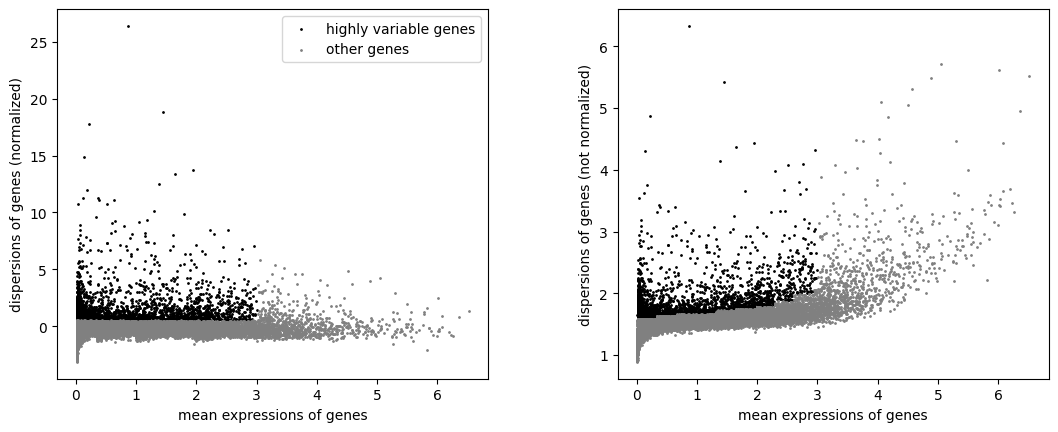

In [16]:
sc.pp.highly_variable_genes(adata, layer='counts', flavor='seurat')
adata.var['seurat_HVG'] = adata.var['highly_variable']
# print(adata.var['seurat_HVG'])
sc.pl.highly_variable_genes(adata)

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


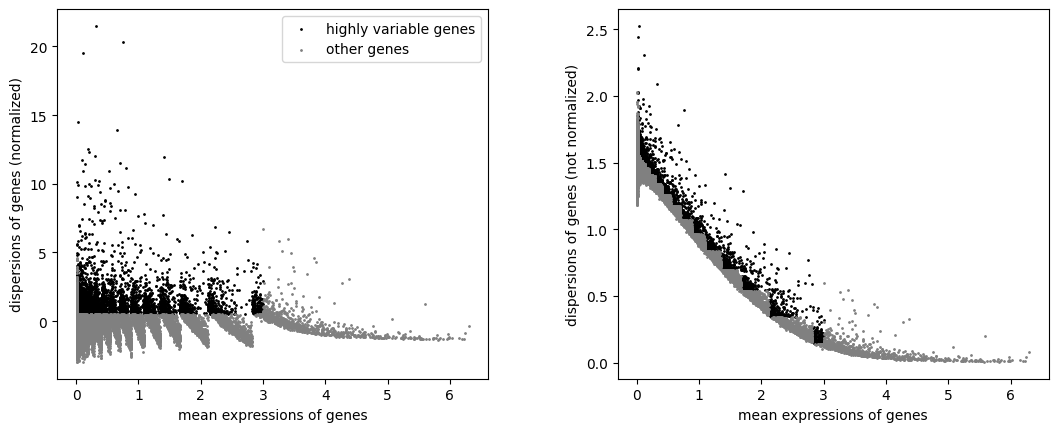

In [17]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger')
adata.var['cell_ranger_HVG'] = adata.var['highly_variable']
# print(adata.var['cell_ranger_HVG'])
sc.pl.highly_variable_genes(adata)

Finds the union and intersection of all the different <br>
Highly Variable Genes (HVGs) <br>


In [18]:
intersection_genes = list(set(adata.var_names[adata.var['cell_ranger_HVG']]) & set(adata.var_names[adata.var['seurat_HVG']]) & set(adata.var_names[adata.var['seurat_v3_HVG']]))
print(f'number of intersection gene: {len(intersection_genes)}')

union_genes = list(set(adata.var_names[adata.var['cell_ranger_HVG']])) + list(set(adata.var_names[adata.var['seurat_HVG']])) + list(set(adata.var_names[adata.var['seurat_v3_HVG']]))
union_genes = list(set(union_genes))
print(f'number of union genes: {len(union_genes)}')

number of intersection gene: 1587
number of union genes: 7541


Saves list of HVG genes, intersection, and Union

In [19]:
# Create a directory to save the genes names called HVG in current directory
if not os.path.exists('HVG'):
    os.makedirs('HVG')

# Save the genes names as csv files in HVG directory
pd.DataFrame(union_genes).to_csv('HVG/union_genes.csv', index = False)
pd.DataFrame(intersection_genes).to_csv('HVG/intersection_genes.csv', index = False)
pd.DataFrame(adata.var_names[adata.var['cell_ranger_HVG']]).to_csv('HVG/cell_ranger_HVG.csv', index = False)
pd.DataFrame(adata.var_names[adata.var['seurat_HVG']]).to_csv('HVG/seurat_HVG.csv', index = False)
pd.DataFrame(adata.var_names[adata.var['seurat_v3_HVG']]).to_csv('HVG/seurat_v3_HVG.csv', index = False)



<p> Were gonna roll with the least stingit HVG list, which is the Union gene list, I think this is the right choose for the time being because this only add computational demand and doesnt risk missing biological insight </p>

In [20]:
union_genes_set = set(union_genes)
is_in_union = [gene in union_genes_set for gene in adata.var_names]

adata.var['highly_variable'] = is_in_union


In [21]:
adata = adata[:, adata.var.highly_variable]

Regression Out additional effect

In [22]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


# Lower Dimensional representation
PCA

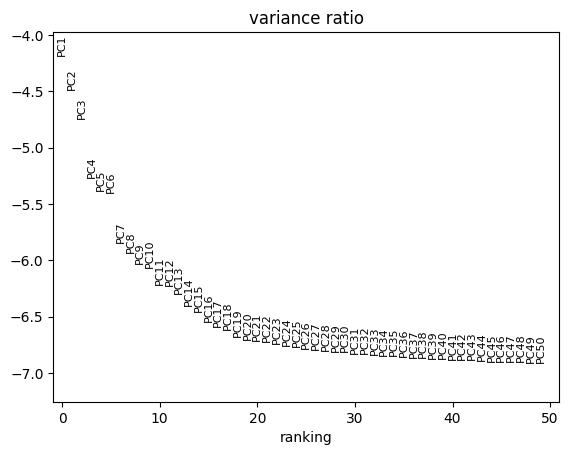

In [23]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

Pre-scVI UMAP space

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

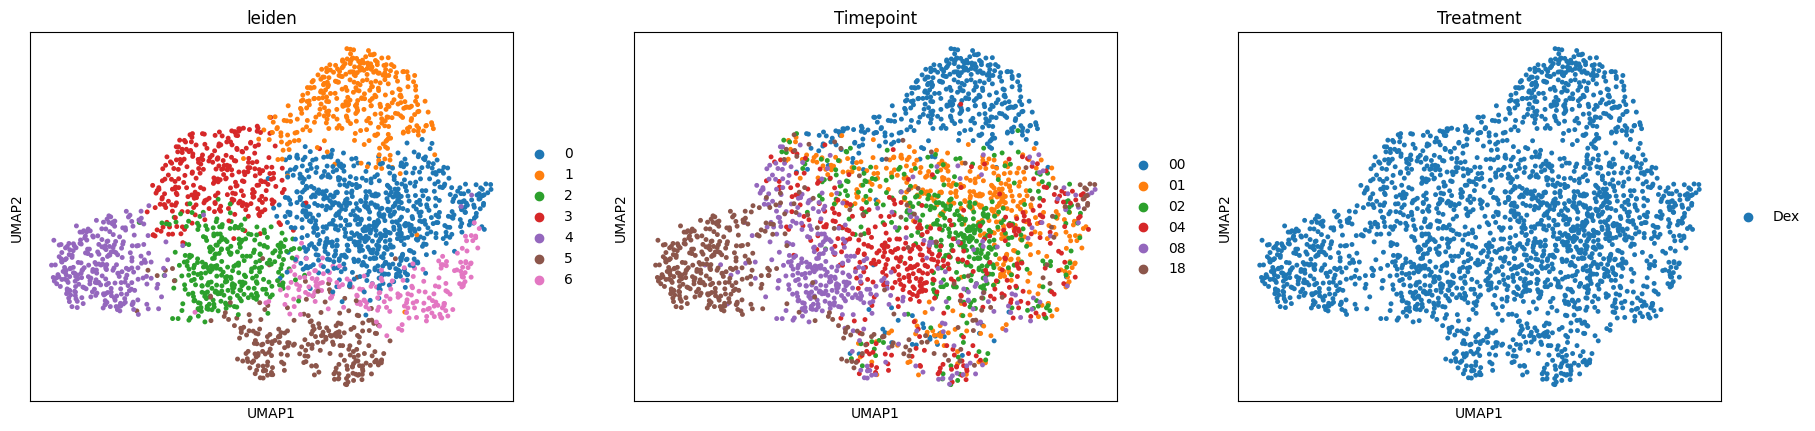

In [24]:
sc.pp.neighbors(adata, n_pcs = 30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color=['leiden', 'Timepoint', 'Treatment'])

# Base scVI

set up scVI model

In [25]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])
model = scvi.model.SCVI(adata)
model.train()

/usr/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/400:   0%|          | 1/400 [00:00<02:27,  2.70it/s, v_num=1, train_loss_step=7.75e+3, train_loss_epoch=8.46e+3]

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 400/400: 100%|██████████| 400/400 [01:05<00:00,  6.21it/s, v_num=1, train_loss_step=5.39e+3, train_loss_epoch=5.41e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:05<00:00,  6.08it/s, v_num=1, train_loss_step=5.39e+3, train_loss_epoch=5.41e+3]


scVI PCA

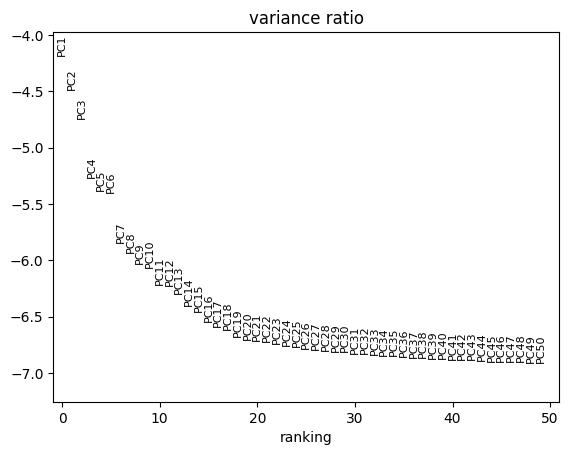

In [26]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

scVI latent space UMAP

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

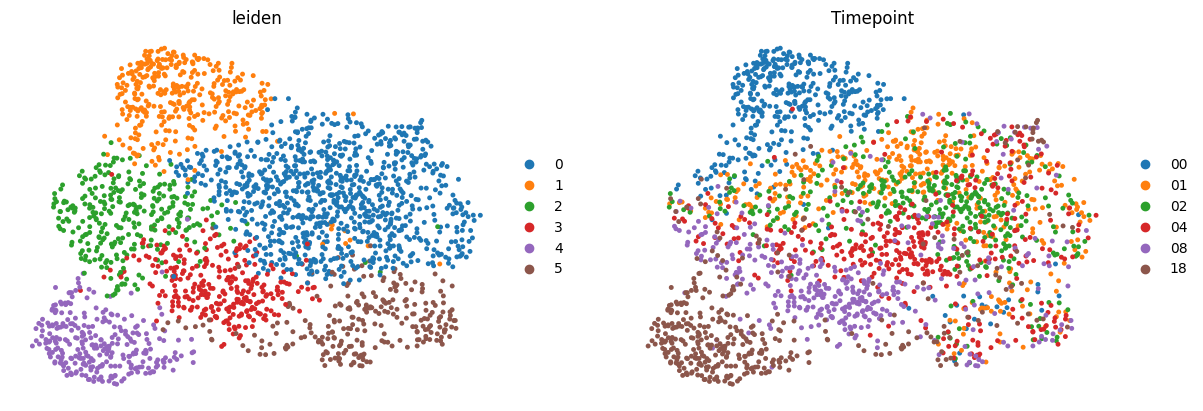

In [27]:
adata.obsm['X_scVI'] = model.get_latent_representation()
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color = ['leiden', 'Timepoint'], frameon = False)

Save scVI normalized adata 

In [28]:
# Specify the directory path
directory = 'data'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the adata object
adata.write(os.path.join(directory, 'adata_scVI_normalized.h5ad'))



# Differential Expression Using scVI

DE for each time point vs the rest of the tps

In [29]:
DE_tp_vs_alltps = model.differential_expression(groupby = 'Timepoint')

DE...: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


In [ ]:
# Simplify the Dataframe so that there is only one row per gene
measurement_types = ['proba_de',
                        'proba_not_de',
                        'bayes_factor',
                        'lfc_mean',
                        'lfc_median',
                        'lfc_std',
                        'lfc_min',
                        'lfc_max',
                        'raw_normalized_mean1',
                        'raw_normalized_mean2',
                        'is_de_fdr_0.05']
comparisons = list(set(DE_tp_vs_alltps['comparison'].to_list()))
column_names = []
for comparison in comparisons:
    for measurement_type in measurement_types:
        column_names.append(f'{comparison}_{measurement_type}')

df_tp_vs_alltps = pd.DataFrame(index=list(set(DE_tp_vs_alltps.index)), columns=column_names)


# Fill the Dataframe with the values from the DE Dataframe
for index, row in DE_tp_vs_alltps.iterrows():
    comparison = row['comparison']
    for measurement_type in measurement_types:
        df_tp_vs_alltps.loc[index, f'{comparison}_{measurement_type}'] = row[measurement_type]


In [ ]:
# Save the differential expression results
# Create a directory to save the results 
if not os.path.exists('DE_results'):
    os.makedirs('DE_results')

# Save the differential expression results
df_tp_vs_alltps.to_csv('DE_results/DE_tp_vs_alltps.csv')


DE for each individual TP vs TP

In [32]:
tvt = []
for t1 in adata.obs.Timepoint.cat.categories:
    for t2 in adata.obs.Timepoint.cat.categories:
        if t1 != t2:
            DE_invidual_tp_v_tp = model.differential_expression(groupby = 'Timepoint', group1 = t1, group2 = t2)
            tvt.append(DE_invidual_tp_v_tp)


DE...: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


In [34]:
DE_tp_vs_tp = pd.concat(tvt)

In [41]:
measurement_types = ['proba_de',
                        'proba_not_de',
                        'bayes_factor',
                        'lfc_mean',
                        'lfc_median',
                        'lfc_std',
                        'lfc_min',
                        'lfc_max',
                        'raw_normalized_mean1',
                        'raw_normalized_mean2',
                        'is_de_fdr_0.05']

comparisons = list(set(DE_tp_vs_tp['comparison'].to_list()))
comparisons = [c for c in comparisons if int(c.split(' ')[0]) < int(c.split(' ')[2])]
column_names = []
for comparison in comparisons:
    for measurement_type in measurement_types:
        column_names.append(f'{comparison}_{measurement_type}')

df_tp_vs_tp = pd.DataFrame(index=list(set(DE_tp_vs_tp.index)), columns=column_names)


# Fill the Dataframe with the values from the DE Dataframe
for index, row in DE_tp_vs_tp.iterrows():
    comparison = row['comparison']
    for measurement_type in measurement_types:
        df_tp_vs_tp.loc[index, f'{comparison}_{measurement_type}'] = row[measurement_type]


/tmp/ipykernel_5306/3366014903.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_tp_vs_tp.loc[index, f'{comparison}_{measurement_type}'] = row[measurement_type]
/tmp/ipykernel_5306/3366014903.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_tp_vs_tp.loc[index, f'{comparison}_{measurement_type}'] = row[measurement_type]
/tmp/ipykernel_5306/3366014903.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_tp_vs_tp.loc[index, f'{comparison}_{measurement_type}'] = row[measuremen

In [43]:
df_tp_vs_tp.to_csv('DE_results/DE_tp_vs_tp.csv')

In [44]:
comparisons

['01 vs 18',
 '01 vs 08',
 '00 vs 02',
 '01 vs 04',
 '02 vs 04',
 '04 vs 18',
 '00 vs 01',
 '02 vs 18',
 '01 vs 02',
 '00 vs 08',
 '00 vs 04',
 '00 vs 18',
 '04 vs 08',
 '08 vs 18',
 '02 vs 08']